# Explainable AI (Occlusion Analysis)
## In this notebook, Occlusion Analysis code and outputs can be found. This has been applied on both Model E and F. However, the goal of this part was to only perform it on Model F, as this was the best performing model in terms of classification.

## Approach
1. Data acquisition
2. Data export and visualization
3. Preprocessing of MRI scans
4. Dataset preparation with PyTorch and Lightning
5. Models (5.1 Model E, 5.2 Model F)
6. Load Models from Checkpoints
7. Explainability of Model F via Occlusion Analysis

## Requirements
- Python 3.x
- PyTorch and PyTorch Lightning
- torchvision
- OpenCV
- NumPy, Matplotlib
- Kaggle Hub
- scipy
- sklearn.metrics
- h5py (for reading MATLAB files)
- Standard libraries (os, random)

## Author
[Horia Ionescu] <br>
[Supervisor Enrique Hortal Quesada] <br>
[Department of Advanced Computing Sciences] <br>
[Faculty of Science and Engineering] <br>
[Maastricht University, The Netherlands] <br>

# 1. Import Data from Kaggle
### Note : This cell can be skipped in every notebook if data was put by you from the *Google Drive* into the `data_figshare` folder in this project, as described in the `README.md` file.

### In case this was not done, either follow the instructions in `README.md` or please make sure to run the next code cell in all notebooks and under section *2. Export from MATLAB and Visualize* comment out line 11:
    data_dir = 'data_figshare/data'
### and uncomment lines 8 and 9:
    path = path + "/dataset/data"
    data_dir = path

In [ ]:
import kagglehub

path = kagglehub.dataset_download("ashkhagan/figshare-brain-tumor-dataset")

print("Path to dataset files:", path)

# 2. Export from MATLAB and Visualize

In [ ]:
import random
import numpy as np
import h5py
import os
import cv2
import matplotlib.pyplot as plt

# path = path + "/dataset/data"
# data_dir = path

data_dir = 'data_figshare/data'
total_images = 3064

X_tumor = []
Y_tumor_mask = []
tumor_labels = []


for i in range(1, total_images + 1):
    filename = str(i) + ".mat"
    file_path = os.path.join(data_dir, filename)

    # mat file using h5py (for matlab v7.3 files)
    with h5py.File(file_path, "r") as data:
        # image resize and normalize
        image = np.array(data["cjdata"]["image"])
        image = cv2.resize(image, (256, 256))  # 256x256
        image = image / 255.0  # normalize pixel val to be [0,1]
        X_tumor.append(image)

        # same goes for mask resize and threshold into binary img
        mask = np.array(data["cjdata"]["tumorMask"])
        mask = cv2.resize(mask, (256, 256))
        mask = (mask > 0).astype(np.uint8)  # this is conversion to binary img
        Y_tumor_mask.append(mask)

        # tumor label 1 -> meningioma  2 -> glioma  3 -> pituitary
        label = int(np.array(data["cjdata"]["label"])[0][0] - 1)
        tumor_labels.append(label)

# lists to numpy arr
# add extra channel dimension for compatibility with most deep learning models , this is grayscale
X_tumor = np.array(X_tumor).reshape(-1, 256, 256, 1)
Y_tumor_mask = np.array(Y_tumor_mask).reshape(-1, 256, 256, 1)
tumor_labels = np.array(tumor_labels)


print("Dataset shapes:")
print("X_tumor:", X_tumor.shape)
print("Y_tumor_mask:", Y_tumor_mask.shape)
print("Tumor labels:", tumor_labels.shape)
print("Unique labels:", np.unique(tumor_labels))


# visualize

num_samples = 5

sample_indices = random.sample(range(len(X_tumor)), num_samples)

for idx in sample_indices:
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(X_tumor[idx].squeeze(), cmap='gray')
    plt.title(f"Tumor Image\nLabel: {tumor_labels[idx]}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(Y_tumor_mask[idx].squeeze(), cmap='gray')
    plt.title("Tumor Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# 256x256x1 needed for segmentation
# for classification, we'll need 256x256x3 , 3 channel rgb

# 3. Preprocessing of MRI Scans

In [ ]:
# resize 256x256x1 already done
# normalization already done
# grayscale as well, here we just do a check to ensure all are greyscale
# and padding to ensure uniformity

target_height = 256
target_width = 256

def check_and_pad(image, target_height, target_width):
    current_height, current_width = image.shape[:2]

    # return if image is already in required measurements
    if current_height == target_height and current_width == target_width:
        return image

    # padding calc
    pad_height = target_height - current_height
    pad_width = target_width - current_width

    if image.ndim == 3:
        padded_image = np.pad(image, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant', constant_values=0)
    else:
        padded_image = np.pad(image, ((0, pad_height), (0, pad_width)), mode='constant', constant_values=0)
    return padded_image


X_tumor_processed = []


for img in X_tumor:
    # convert to grayscale in case it doesnt have enough channels
    if img.ndim == 3 and img.shape[-1] != 1:
        # convert from [0,1] to [0,255] for cv2 manipulation
        img_8bit = (img * 255).astype(np.uint8)
        img_gray = cv2.cvtColor(img_8bit, cv2.COLOR_BGR2GRAY)
        # go back to [0,1] and expand dimensions to add channel dimension
        img_gray = img_gray.astype(np.float32) / 255.0
        img = np.expand_dims(img_gray, axis=-1)

    img_2d = img.squeeze()
    img_padded = check_and_pad(img_2d, target_height, target_width)
    img_final = np.expand_dims(img_padded, axis=-1)
    X_tumor_processed.append(img_final)

X_tumor_processed = np.array(X_tumor_processed)
print("Processed X_tumor shape:", X_tumor_processed.shape)

# 4. Custom DataModule via PyTorch Lightning DataModule

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl

# torch.manual_seed(42)

# dataset class
class BrainTumorDataset_multi(Dataset):
    def __init__(self, images, masks, labels, transform=None):
        """
        images -> numpy array of shape (N, 256, 256, 1)
        masks -> numpy array of shape (N, 256, 256, 1)
        images and masks have same shape (and should have)
        labels -> numpy array of shape (N,)
        """
        self.images = images
        self.masks = masks
        self.labels = labels  # added for classification
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # # make images, masks and labels torch tensors and squeeze channel dim if necessary
        image = torch.tensor(self.images[idx], dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(self.masks[idx], dtype=torch.float32).permute(2, 0, 1)
        label = self.labels[idx]  # 0, 1, 2

        return image, mask, label


    # Lightning dataModule
class BrainTumorDataModule_multi(pl.LightningDataModule):
    def __init__(self, images, masks, labels, batch_size=16, val_split=0.1, test_split=0.2, num_workers=0):
        super().__init__()
        self.images = images
        self.masks = masks
        self.labels = labels  # added labels here
        self.batch_size = batch_size
        self.val_split = val_split
        self.test_split = test_split
        self.num_workers = num_workers

    def setup(self, stage=None):
        # create the full version of the dataset, now includes labels
        full_dataset = BrainTumorDataset_multi(self.images, self.masks, self.labels)
        dataset_size = len(full_dataset)

        # split sizes
        test_size = int(self.test_split * dataset_size)
        val_size = int(self.val_split * (dataset_size - test_size))
        train_size = dataset_size - test_size - val_size

        # use generator with seed to ensure same items every run
        gen = torch.Generator().manual_seed(42)

        # this randomly splits the dataset
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            full_dataset, [train_size, val_size, test_size],
            generator = gen
        )
        print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")

    # this will be used for training
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                          shuffle=True, num_workers=self.num_workers)

    # .... for validation
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)

    # .... for testing
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)


# instantiate data module, batch size already set
data_module_multi = BrainTumorDataModule_multi(X_tumor_processed, Y_tumor_mask, tumor_labels)
data_module_multi.setup()

# initialize loaders
train_loader_multi = data_module_multi.train_dataloader()
test_loader_multi = data_module_multi.test_dataloader()
for batch in train_loader_multi:
    images, masks, labels = batch  # technically, it should also include labels
    print("Batch images shape:", images.shape)  # should be (batch_size, 1, 256, 256)
    print("Batch masks shape:", masks.shape)    # same here
    print("Batch labels shape:", labels.shape)  # should be (batch_size,)
    break

# this shows how many samples from the test set are for each type of tumor
from collections import Counter
label_counts = Counter()

for images, masks, labels in test_loader_multi:
    label_counts.update(labels.numpy())

for label in sorted(label_counts):
    print(f'Label {label} has {label_counts[label]} images in test set.')

# 5. Models

# 5.1 Model E

In [11]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
pl.seed_everything(42)
torch.cuda.manual_seed_all(42)  # for gpu usage
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Model with Classification Logits and Segmentation Decoder Modification
class FCNResNet50Lightning_5_1_1(pl.LightningModule):
    def __init__(
            self,
            num_seg_classes: int = 1,
            num_cls_classes: int = 3,
            lr: float = 1e-3,
            seg_weight: float = 0.85,
            cls_weight: float = 0.15,
            bce_weight: float = 0.5,
            dice_weight: float = 0.5
    ):
        super().__init__()
        self.save_hyperparameters()

        # 1) load and adjust FCN-ResNet50 for segmentation
        self.model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
        self.model.classifier[4] = nn.Conv2d(512, num_seg_classes, kernel_size=1)
        if hasattr(self.model, 'aux_classifier'):
            self.model.aux_classifier[4] = nn.Conv2d(256, num_seg_classes, kernel_size=1)

        # 2) projection for classifier logits → 2048 channels
        self.cls_proj = nn.Linear(num_cls_classes, 2048)

        # 3) classification head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_cls_classes)
        )

        # losses
        self.bce_loss_fn = nn.BCEWithLogitsLoss()
        self.cls_loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        # ensure 3 channels
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)

        # encoder features
        features = self.model.backbone(x)['out']  # [B,2048,H,W]

        # classification
        class_logits = self.classifier(features)  # [B,3]

        # project & add back to features
        cls_embed = self.cls_proj(class_logits)        # [B,2048]
        cls_embed = cls_embed.view(-1, 2048, 1, 1)     # [B,2048,1,1]
        features = features + cls_embed                # broadcast add

        # segmentation decoder
        seg_logits = self.model.classifier(features)    # [B,1,H/8,W/8]
        seg_logits = F.interpolate(
            seg_logits,
            size=x.shape[2:],                          # up to original H,W
            mode='bilinear',
            align_corners=False
        )

        return seg_logits, class_logits

    def dice_loss(self, probs, targets, eps=1e-6):
        inter = (probs * targets).sum(dim=(2, 3))
        union = probs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice  = 2.0 * inter / (union + eps)
        return 1 - dice.mean()

    def combined_seg_loss(self, logits, masks):
        bce   = self.bce_loss_fn(logits, masks)
        probs = torch.sigmoid(logits)
        dice  = self.dice_loss(probs, masks)
        return self.hparams.bce_weight * bce + self.hparams.dice_weight * dice

    def training_step(self, batch, batch_idx):
        images, masks, labels = batch
        seg_logits, class_logits = self(images)

        seg_loss = self.combined_seg_loss(seg_logits, masks)
        cls_loss = self.cls_loss_fn(class_logits, labels)

        total_loss = self.hparams.seg_weight * seg_loss + self.hparams.cls_weight * cls_loss

        self.log('train_seg_loss', seg_loss, prog_bar=True)
        self.log('train_cls_loss', cls_loss, prog_bar=True)
        self.log('train_loss', total_loss, prog_bar=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        images, masks, labels = batch
        seg_logits, class_logits = self(images)

        seg_loss = self.combined_seg_loss(seg_logits, masks)
        cls_loss = self.cls_loss_fn(class_logits, labels)
        total_loss = self.hparams.seg_weight * seg_loss + self.hparams.cls_weight * cls_loss

        self.log('val_seg_loss', seg_loss, prog_bar=True)
        self.log('val_cls_loss', cls_loss, prog_bar=True)
        self.log('val_loss', total_loss, prog_bar=True)
        return total_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

Seed set to 42


# 5.2 Model F

In [12]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
pl.seed_everything(42)
torch.cuda.manual_seed_all(42)  # for gpu usage
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Model with Segmentation Logits
class FCNResNet50Lightning_5_1_2(pl.LightningModule):
    def __init__(
            self,
            num_seg_classes: int = 1,
            num_cls_classes: int = 3,
            lr: float = 1e-3,
            seg_weight: float = 0.85,
            cls_weight: float = 0.15,
            bce_weight: float = 0.5,
            dice_weight: float = 0.5
    ):
        super().__init__()
        self.save_hyperparameters()

        # 1) Load and adjust FCN-ResNet50 for segmentation
        self.model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
        self.model.classifier[4] = nn.Conv2d(512, num_seg_classes, kernel_size=1)
        if hasattr(self.model, 'aux_classifier'):
            self.model.aux_classifier[4] = nn.Conv2d(256, num_seg_classes, kernel_size=1)

        # 2) Create a segmentation feature extractor
        # This will extract features from segmentation decoder
        self.seg_feature_extractor = nn.Sequential(
            nn.Conv2d(num_seg_classes, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2)
        )

        # 3) Classification head that integrates backbone features and segmentation features
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(2048 + 64, 512),  # 2048 from backbone + 64 from seg features
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_cls_classes)
        )

        # Losses
        self.bce_loss_fn = nn.BCEWithLogitsLoss()
        self.cls_loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        # Ensure 3 channels
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)

        # Get encoder features
        features = self.model.backbone(x)['out']  # [B,2048,H,W]

        # Run segmentation decoder
        seg_logits = self.model.classifier(features)  # [B,1,H/8,W/8]

        # Extract features from segmentation logits
        seg_features = self.seg_feature_extractor(seg_logits)  # [B,64,H/16,W/16]

        # Global average pooling on both feature sets
        global_features = F.adaptive_avg_pool2d(features, 1)  # [B,2048,1,1]
        global_seg_features = F.adaptive_avg_pool2d(seg_features, 1)  # [B,64,1,1]

        # Concatenate both feature types
        combined_features = torch.cat([
            global_features.flatten(1),
            global_seg_features.flatten(1)
        ], dim=1)  # [B,2048+64]

        # Run classifier on combined features
        class_logits = self.classifier[2:](combined_features)  # Skip pooling & flatten

        # Upsample segmentation to original size
        seg_logits_full = F.interpolate(
            seg_logits,
            size=x.shape[2:],
            mode='bilinear',
            align_corners=False
        )

        return seg_logits_full, class_logits

    def dice_loss(self, probs, targets, eps=1e-6):
        inter = (probs * targets).sum(dim=(2, 3))
        union = probs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice = 2.0 * inter / (union + eps)
        return 1 - dice.mean()

    def combined_seg_loss(self, logits, masks):
        bce = self.bce_loss_fn(logits, masks)
        probs = torch.sigmoid(logits)
        dice = self.dice_loss(probs, masks)
        return self.hparams.bce_weight * bce + self.hparams.dice_weight * dice

    def training_step(self, batch, batch_idx):
        images, masks, labels = batch
        seg_logits, class_logits = self(images)

        seg_loss = self.combined_seg_loss(seg_logits, masks)
        cls_loss = self.cls_loss_fn(class_logits, labels)

        total_loss = self.hparams.seg_weight * seg_loss + self.hparams.cls_weight * cls_loss

        self.log('train_seg_loss', seg_loss, prog_bar=True)
        self.log('train_cls_loss', cls_loss, prog_bar=True)
        self.log('train_loss', total_loss, prog_bar=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        images, masks, labels = batch
        seg_logits, class_logits = self(images)

        seg_loss = self.combined_seg_loss(seg_logits, masks)
        cls_loss = self.cls_loss_fn(class_logits, labels)
        total_loss = self.hparams.seg_weight * seg_loss + self.hparams.cls_weight * cls_loss

        self.log('val_seg_loss', seg_loss, prog_bar=True)
        self.log('val_cls_loss', cls_loss, prog_bar=True)
        self.log('val_loss', total_loss, prog_bar=True)
        return total_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

Seed set to 42


# 6. Load Models from Checkpoints

In [13]:
model_cls_into_seg = FCNResNet50Lightning_5_1_1.load_from_checkpoint('checkpoints/Model_E_Classification_Informed_Segmentation.ckpt')
model_seg_into_cls = FCNResNet50Lightning_5_1_2.load_from_checkpoint('checkpoints/Model_F_Segmentation_Informed_Classification.ckpt')

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# 7. Explainability - Occlusion analysis
## Note: Occlusion analysis has been applied to both Models E and F, though the relevant results for the Report are the first 9 heatmaps , gathered from Model F, as this achieved best classification performance.

Model: Segmentation Embeddings into Classification
Processing Meningioma sample 1/3
  Mean Sensitivity Inside Mask: 3.0668
  Mean Sensitivity Outside Mask: -0.7153
  Ratio (Inside/Outside): -4.2874


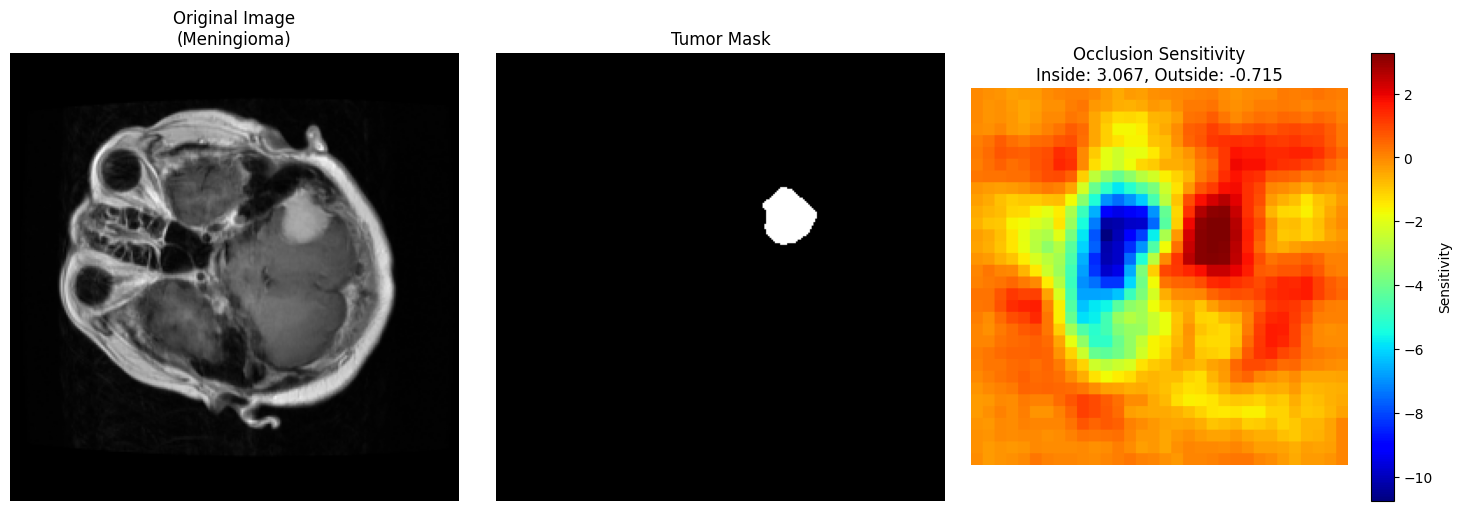

Processing Meningioma sample 2/3
  Mean Sensitivity Inside Mask: -3.1835
  Mean Sensitivity Outside Mask: -1.1102
  Ratio (Inside/Outside): 2.8676


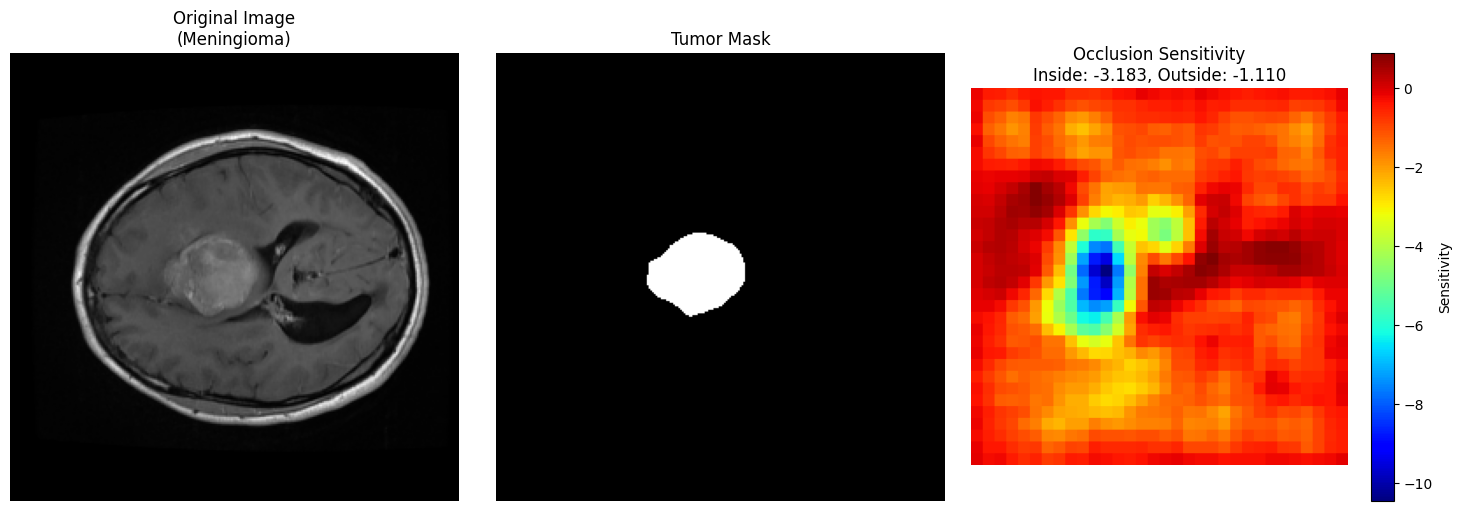

Processing Meningioma sample 3/3
  Mean Sensitivity Inside Mask: 1.8862
  Mean Sensitivity Outside Mask: -1.0675
  Ratio (Inside/Outside): -1.7670


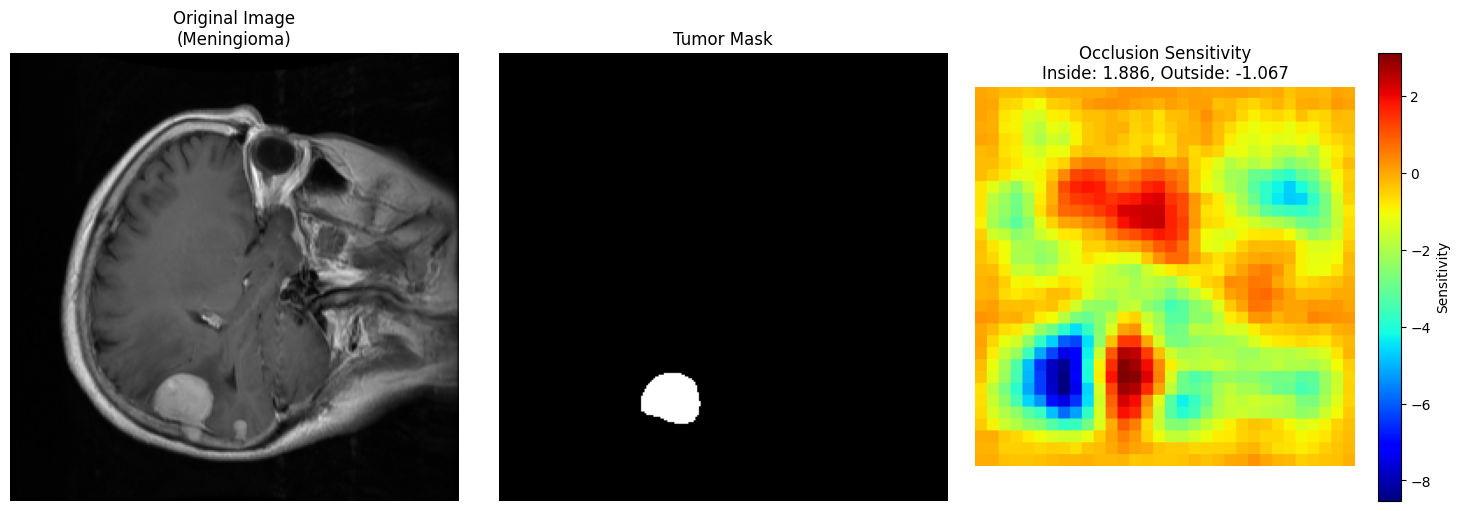

Processing Glioma sample 1/3
  Mean Sensitivity Inside Mask: 6.0039
  Mean Sensitivity Outside Mask: -0.6074
  Ratio (Inside/Outside): -9.8840


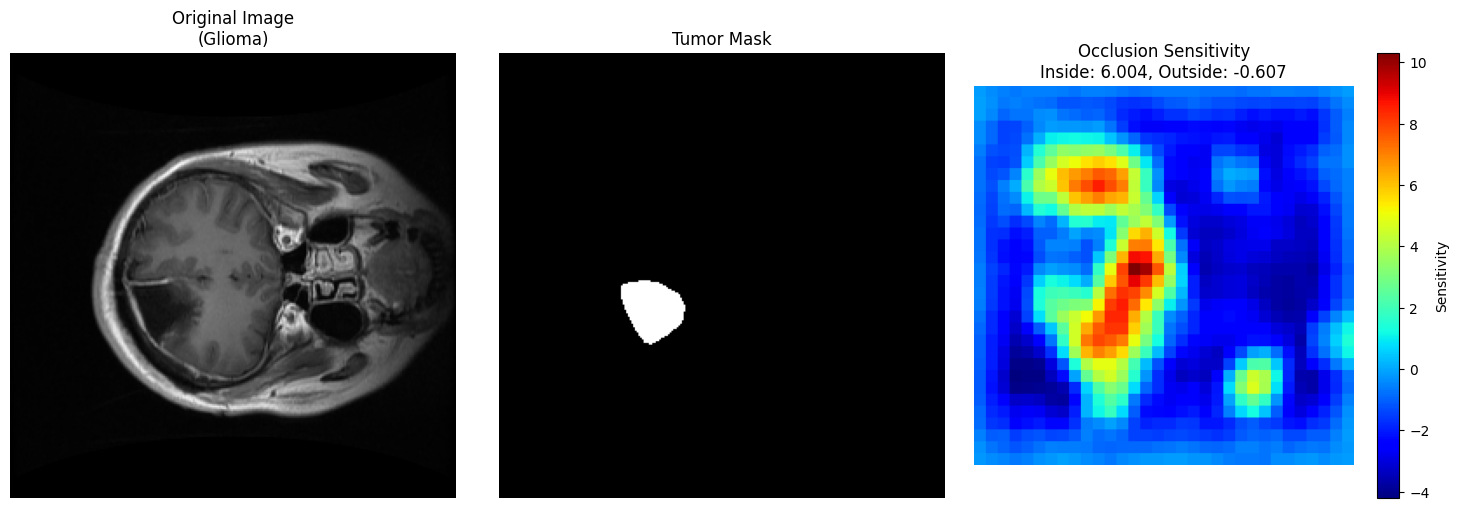

Processing Glioma sample 2/3
  Mean Sensitivity Inside Mask: 7.2550
  Mean Sensitivity Outside Mask: 0.5599
  Ratio (Inside/Outside): 12.9585


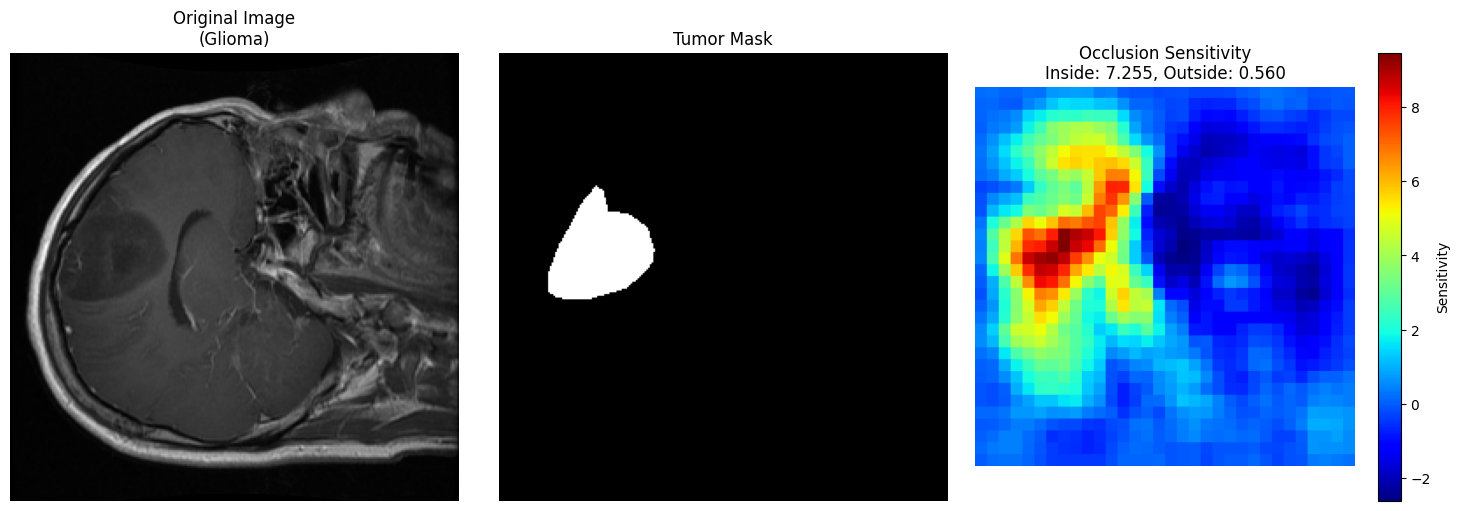

Processing Glioma sample 3/3
  Mean Sensitivity Inside Mask: 2.5864
  Mean Sensitivity Outside Mask: -0.6754
  Ratio (Inside/Outside): -3.8296


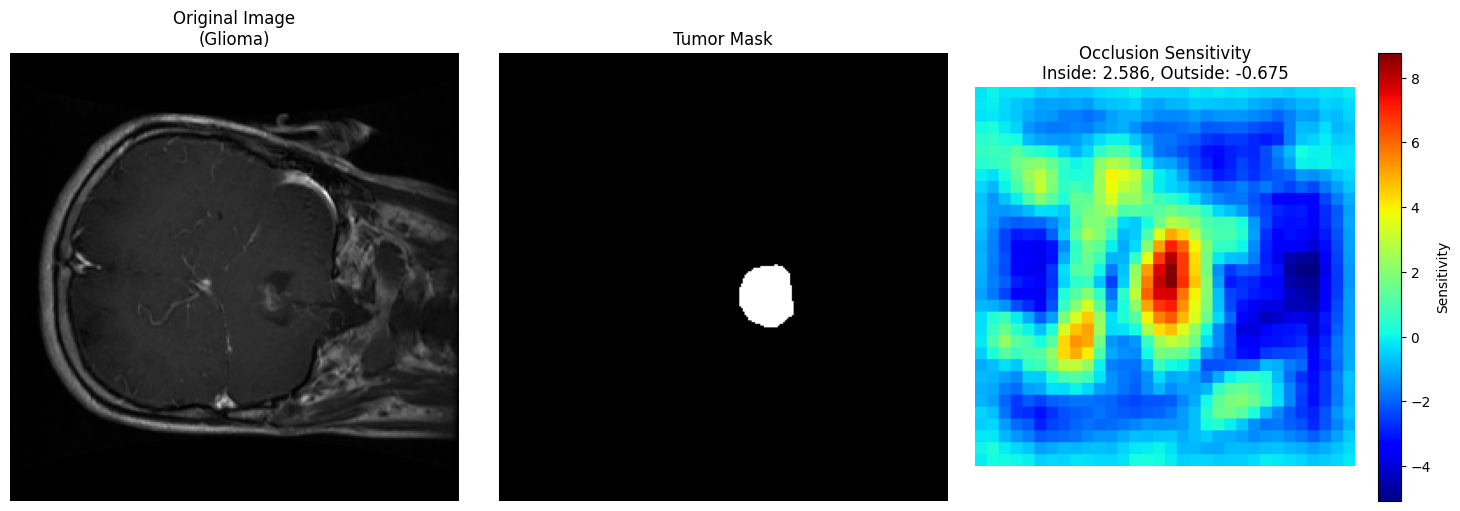

Processing Pituitary sample 1/3
  Mean Sensitivity Inside Mask: 5.4469
  Mean Sensitivity Outside Mask: 1.9241
  Ratio (Inside/Outside): 2.8309


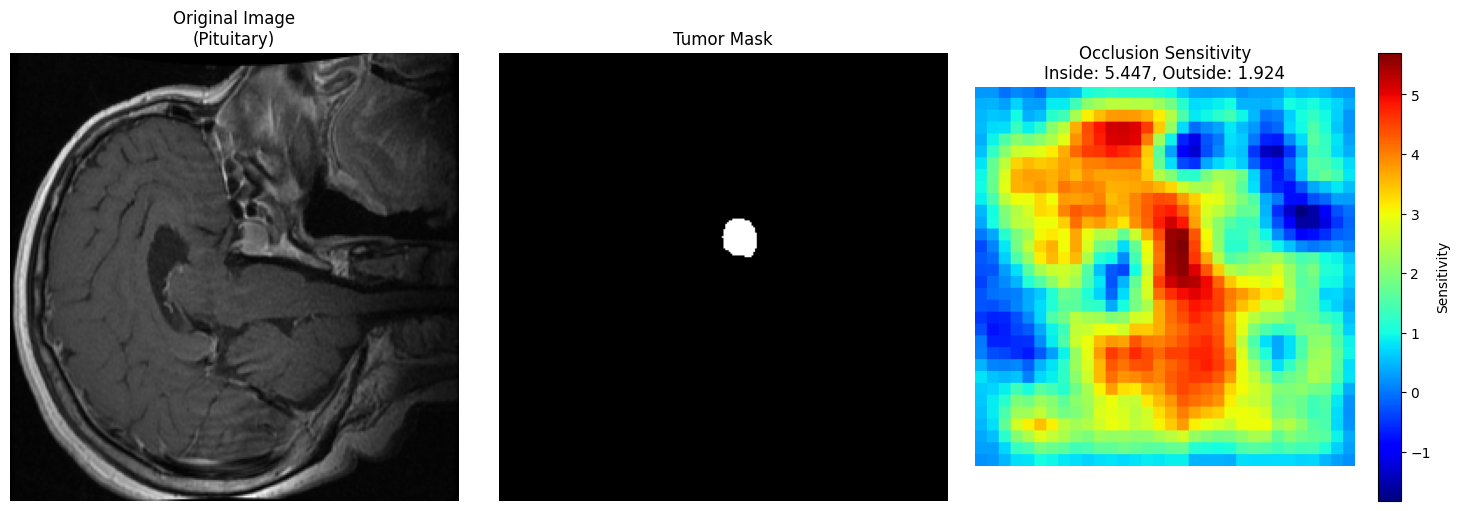

Processing Pituitary sample 2/3
  Mean Sensitivity Inside Mask: 2.4796
  Mean Sensitivity Outside Mask: 1.5964
  Ratio (Inside/Outside): 1.5533


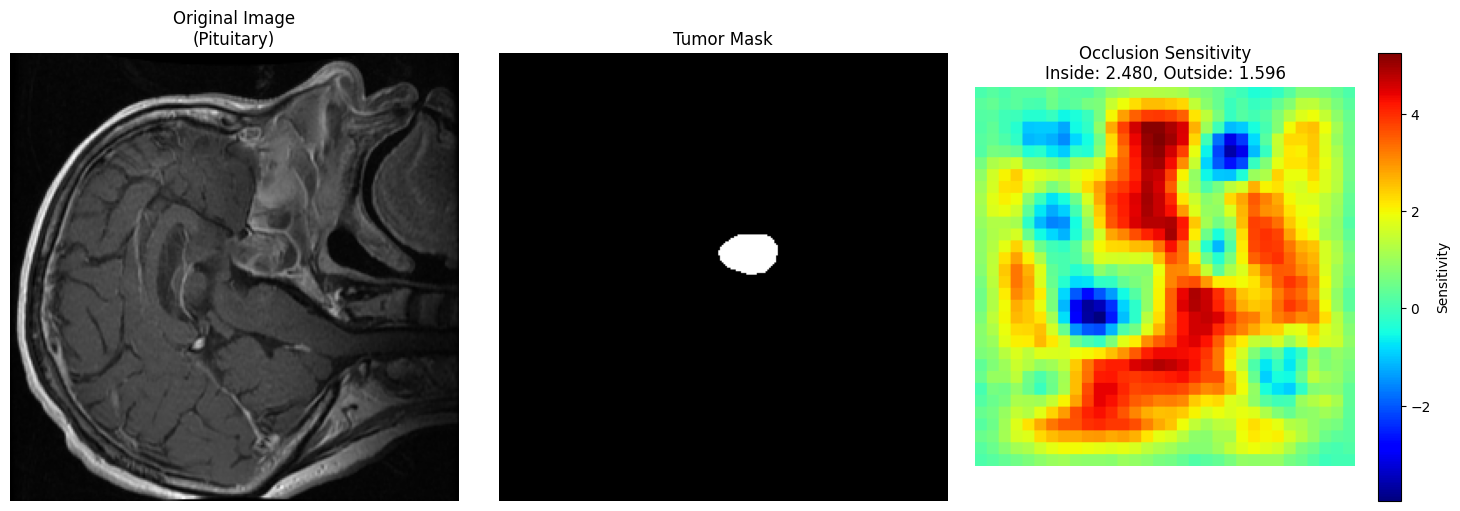

Processing Pituitary sample 3/3
  Mean Sensitivity Inside Mask: 2.7408
  Mean Sensitivity Outside Mask: -1.2038
  Ratio (Inside/Outside): -2.2767


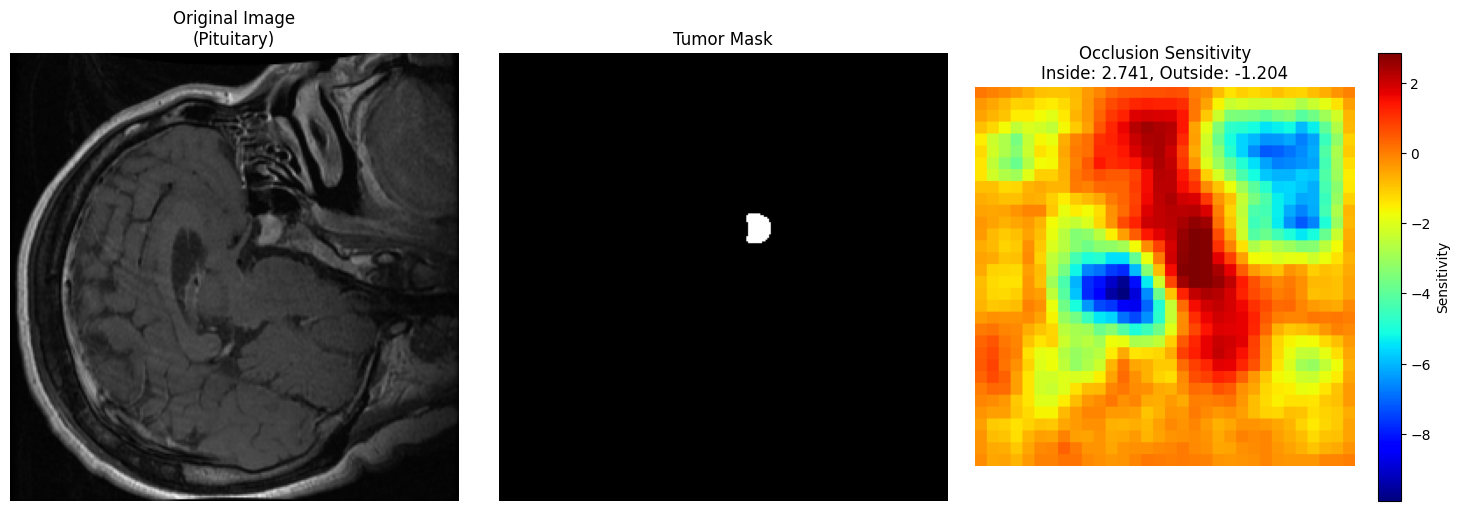


Summary of Mean Sensitivity Inside/Outside by Class:

Meningioma:
  Avg Inside: 0.5899
  Avg Outside: -0.9643
  Avg Ratio: -1.0623

Glioma:
  Avg Inside: 5.2818
  Avg Outside: -0.2410
  Avg Ratio: -0.2517

Pituitary:
  Avg Inside: 3.5558
  Avg Outside: 0.7722
  Avg Ratio: 0.7025

Model: Classification Embeddings into Segmentation
Processing Meningioma sample 1/3
  Mean Sensitivity Inside Mask: 1.2859
  Mean Sensitivity Outside Mask: -1.7744
  Ratio (Inside/Outside): -0.7247


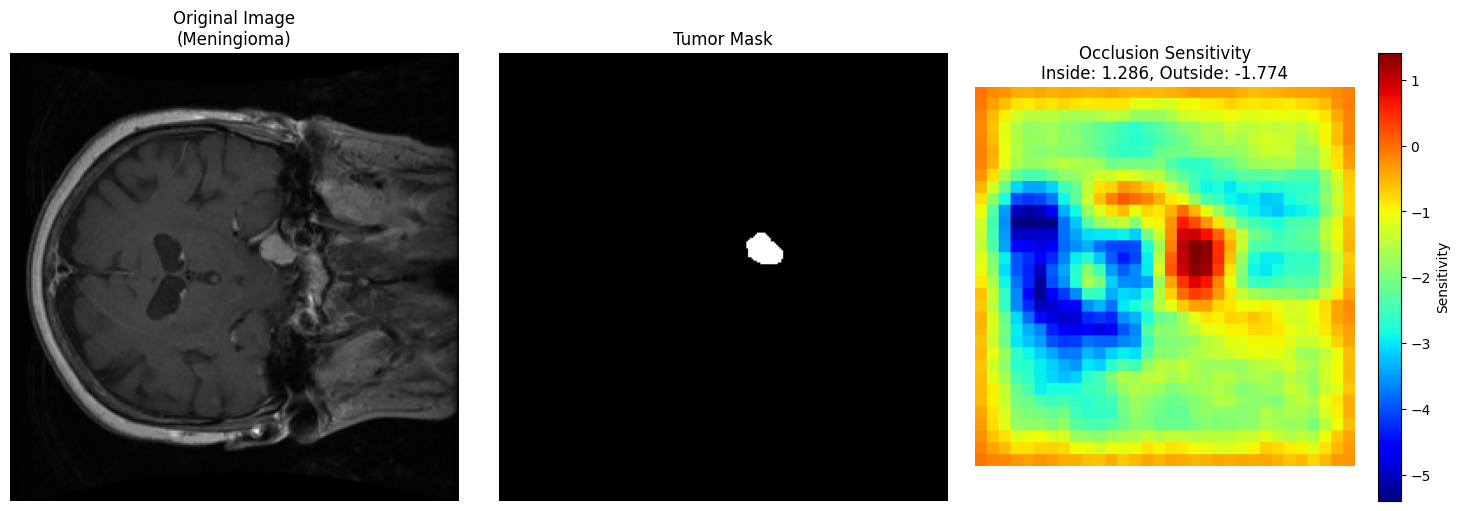

Processing Meningioma sample 2/3
  Mean Sensitivity Inside Mask: 5.7814
  Mean Sensitivity Outside Mask: 0.7778
  Ratio (Inside/Outside): 7.4335


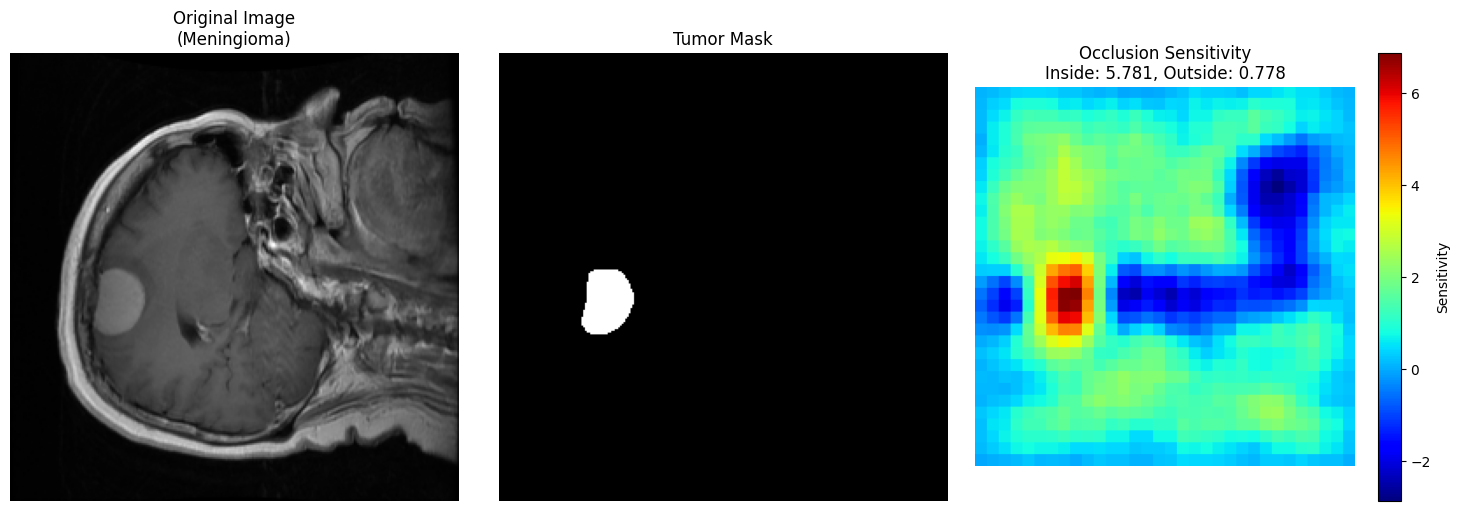

Processing Meningioma sample 3/3
  Mean Sensitivity Inside Mask: 3.8674
  Mean Sensitivity Outside Mask: -0.3595
  Ratio (Inside/Outside): -10.7578


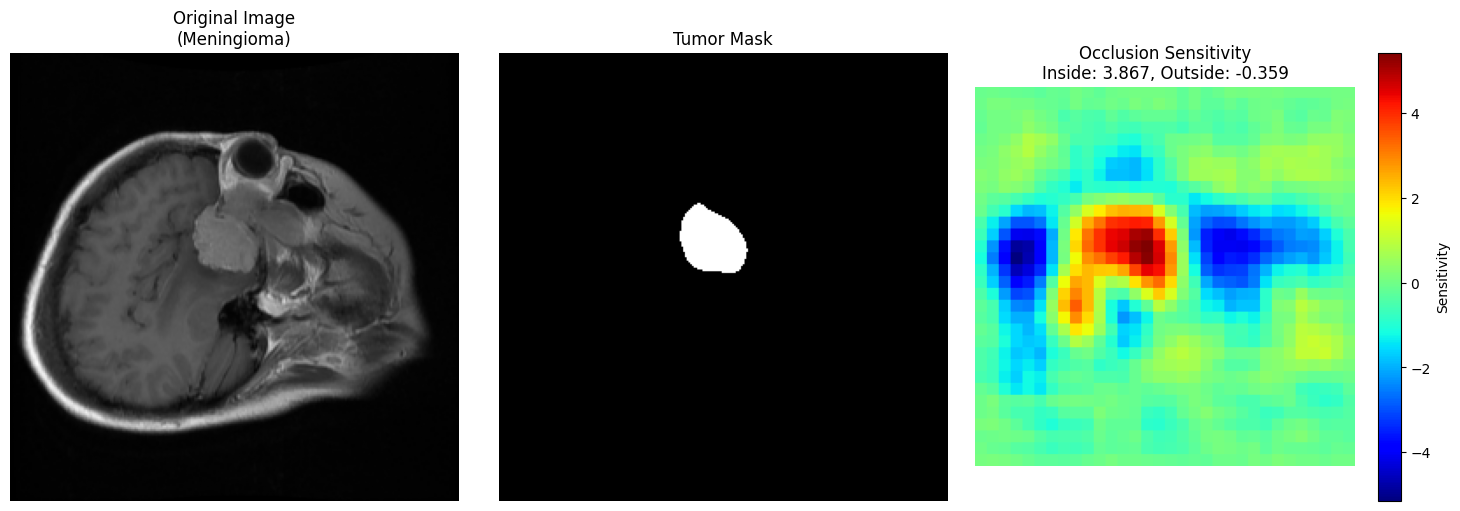

Processing Glioma sample 1/3
  Mean Sensitivity Inside Mask: 3.9178
  Mean Sensitivity Outside Mask: 1.4171
  Ratio (Inside/Outside): 2.7647


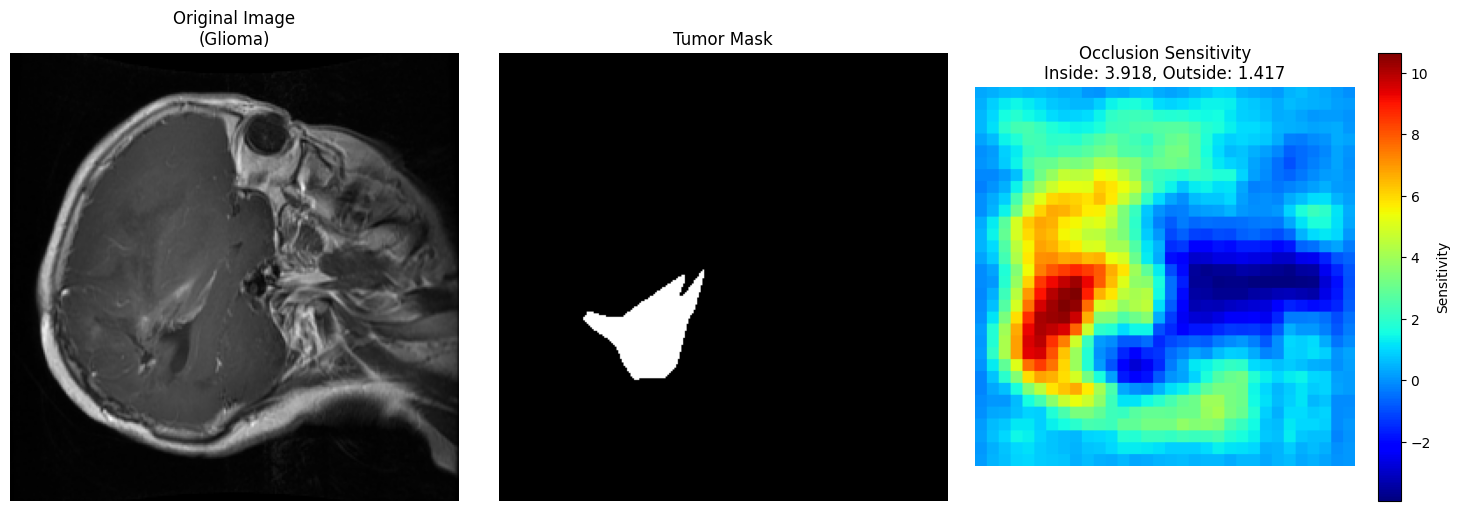

Processing Glioma sample 2/3
  Mean Sensitivity Inside Mask: -4.5355
  Mean Sensitivity Outside Mask: 0.2553
  Ratio (Inside/Outside): -17.7627


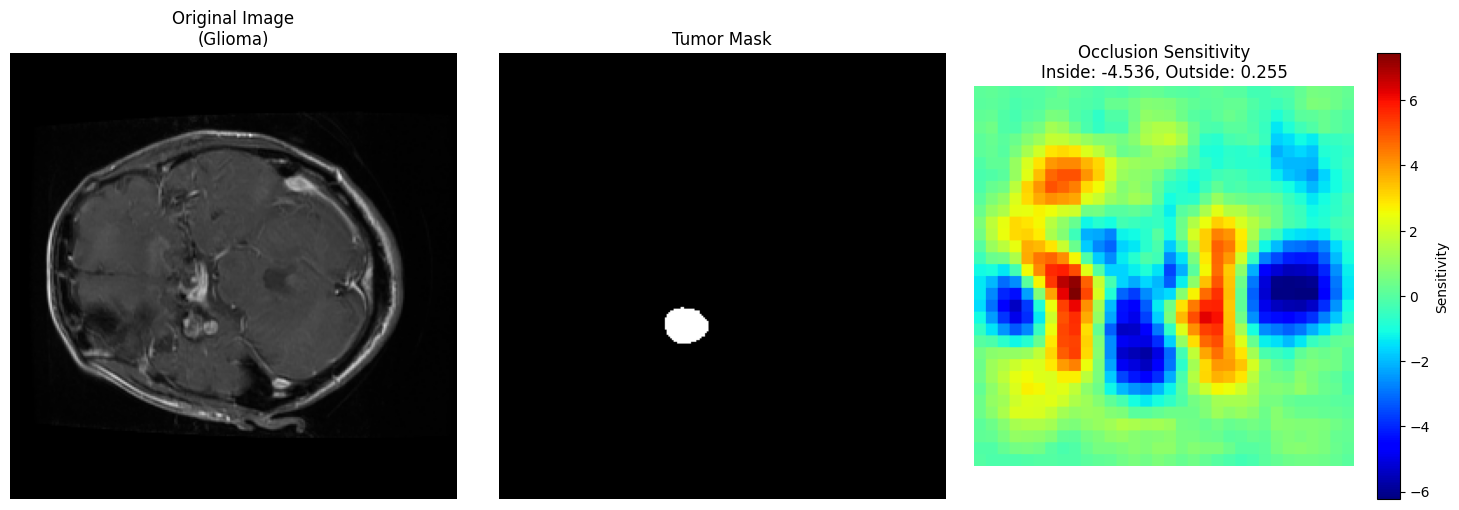

Processing Glioma sample 3/3
  Mean Sensitivity Inside Mask: 4.8158
  Mean Sensitivity Outside Mask: -0.0813
  Ratio (Inside/Outside): -59.1984


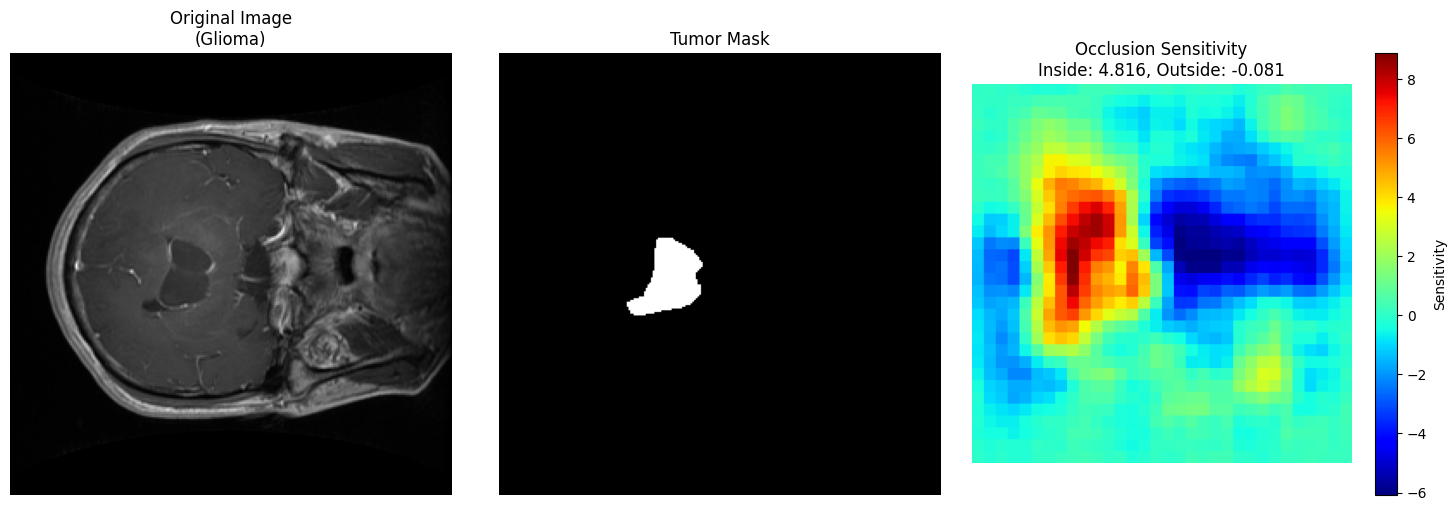

Processing Pituitary sample 1/3
  Mean Sensitivity Inside Mask: 2.5095
  Mean Sensitivity Outside Mask: -0.4615
  Ratio (Inside/Outside): -5.4375


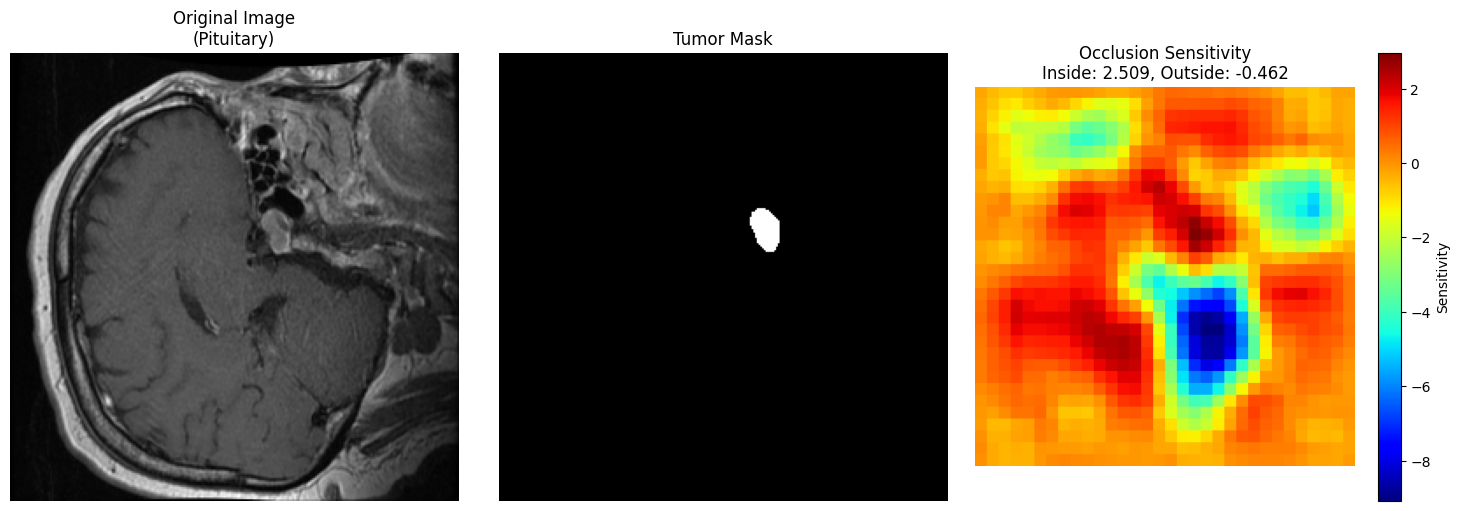

Processing Pituitary sample 2/3
  Mean Sensitivity Inside Mask: 3.8376
  Mean Sensitivity Outside Mask: 0.4917
  Ratio (Inside/Outside): 7.8045


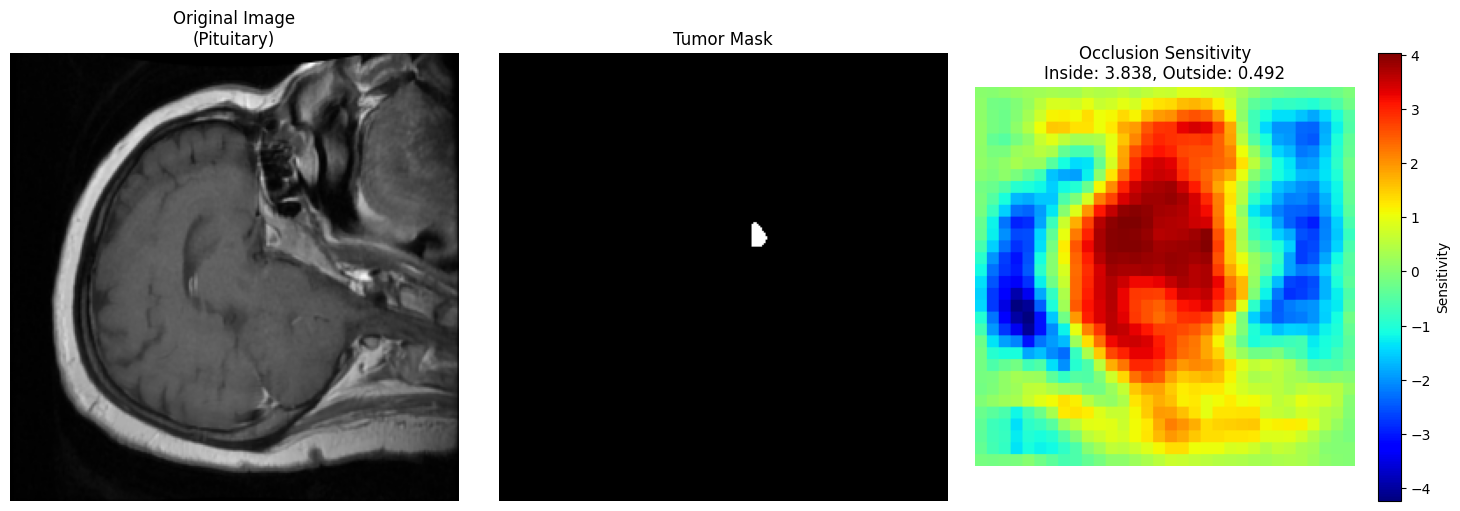

Processing Pituitary sample 3/3
  Mean Sensitivity Inside Mask: 6.2744
  Mean Sensitivity Outside Mask: 2.9616
  Ratio (Inside/Outside): 2.1186


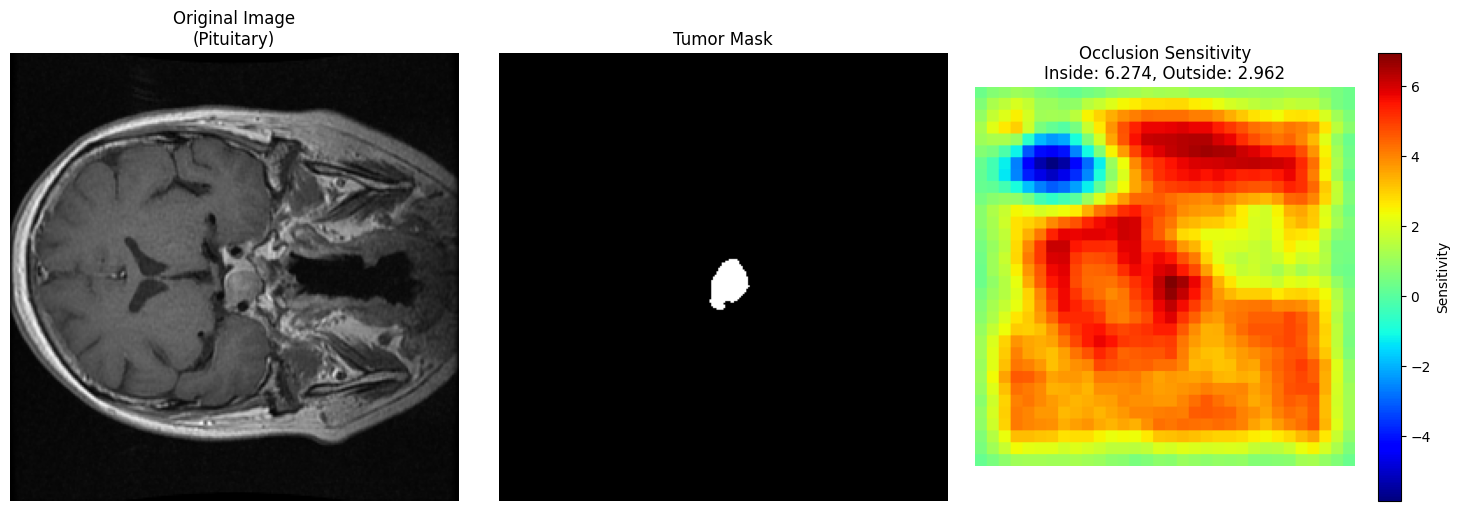


Summary of Mean Sensitivity Inside/Outside by Class:

Meningioma:
  Avg Inside: 3.6449
  Avg Outside: -0.4521
  Avg Ratio: -1.3497

Glioma:
  Avg Inside: 1.3993
  Avg Outside: 0.5304
  Avg Ratio: -24.7321

Pituitary:
  Avg Inside: 4.2072
  Avg Outside: 0.9973
  Avg Ratio: 1.4952


In [14]:
import matplotlib.pyplot as plt

def occlusion_sensitivity(model, image, label, mask_size=32, stride=8, batch_size=32):
    device = next(model.parameters()).device

    if len(image.shape) == 3:
        image = image.unsqueeze(0)

    image = image.to(device)
    width, height = image.shape[2], image.shape[3]

    # get original classification prediction
    with torch.no_grad():
        _, class_logits = model(image)
        original_prob = F.softmax(class_logits, dim=1)[0, label].item()

    # create occlusion patches
    occlusion_map = np.zeros((height, width))

    # generate all occlusion positions
    coords = []
    for h in range(0, height - mask_size + 1, stride):
        for w in range(0, width - mask_size + 1, stride):
            coords.append((h, w))

    # process batches
    for i in range(0, len(coords), batch_size):
        batch_coords = coords[i:i + batch_size]
        batch_images = []

        # create occluded images
        for h, w in batch_coords:
            occluded = image.clone()
            occluded[..., h:h + mask_size, w:w + mask_size] = 0  # this is zero occlusion
            batch_images.append(occluded)

        batch_tensor = torch.cat(batch_images)

        # get pred
        with torch.no_grad():
            _, batch_logits = model(batch_tensor)
            batch_probs = F.softmax(batch_logits, dim=1)

        # keep track of probabilities
        for idx, (h, w) in enumerate(batch_coords):
            prob = batch_probs[idx, label].item()
            diff = original_prob - prob
            occlusion_map[h:h + mask_size, w:w + mask_size] += diff

    return occlusion_map


def run_occlusion_analysis(model, dataset, class_names, num_samples=3):
    data_loader = DataLoader(dataset, batch_size=1, shuffle=True)
    samples_by_class = {i: [] for i in range(len(class_names))}

    results = {cls_name: [] for cls_name in class_names}

    for images, masks, labels in data_loader:
        label = labels.item()
        if len(samples_by_class[label]) < num_samples:
            samples_by_class[label].append((images, masks, labels))

        if all(len(samples) >= num_samples for samples in samples_by_class.values()):
            break

    for class_idx, class_name in enumerate(class_names):
        for i, (images, masks, _) in enumerate(samples_by_class[class_idx]):
            print(f"Processing {class_name} sample {i + 1}/{num_samples}")

            # apply occlusion analysis
            occlusion_map = occlusion_sensitivity(model, images, class_idx)

            # get sensitivity metrics
            mask_np = masks[0, 0].cpu().numpy()
            binary_mask = mask_np > 0

            # get mean sensitivity inside and outside
            sensitivity_inside = occlusion_map[binary_mask].mean() if binary_mask.any() else 0
            sensitivity_outside = occlusion_map[~binary_mask].mean() if (~binary_mask).any() else 0
            ratio = sensitivity_inside / sensitivity_outside if sensitivity_outside != 0 else float('inf')

            # save results
            results[class_name].append({
                'sample': i + 1,
                'mean_sensitivity_inside': sensitivity_inside,
                'mean_sensitivity_outside': sensitivity_outside,
                'ratio': ratio
            })

            print(f"  Mean Sensitivity Inside Mask: {sensitivity_inside:.4f}")
            print(f"  Mean Sensitivity Outside Mask: {sensitivity_outside:.4f}")
            print(f"  Ratio (Inside/Outside): {ratio:.4f}")


            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.imshow(images[0, 0].cpu().numpy(), cmap='gray')
            plt.title(f"Original Image\n({class_name})")
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(masks[0, 0].cpu().numpy(), cmap='gray')
            plt.title("Tumor Mask")
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(occlusion_map, cmap='jet')
            plt.colorbar(label='Sensitivity')
            plt.title(f"Occlusion Sensitivity\nInside: {sensitivity_inside:.3f}, Outside: {sensitivity_outside:.3f}")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

    print("\nSummary of Mean Sensitivity Inside/Outside by Class:")
    for class_name, samples in results.items():
        inside_vals = [s['mean_sensitivity_inside'] for s in samples]
        outside_vals = [s['mean_sensitivity_outside'] for s in samples]
        ratios = [s['ratio'] for s in samples]

        print(f"\n{class_name}:")
        print(f"  Avg Inside: {np.mean(inside_vals):.4f}")
        print(f"  Avg Outside: {np.mean(outside_vals):.4f}")
        print(f"  Avg Ratio: {np.mean(ratios):.4f}")

    return results


class_names = ['Meningioma', 'Glioma', 'Pituitary']

print("Model: Model F")
results = run_occlusion_analysis(model_seg_into_cls, data_module_multi.test_dataset, class_names)

# this is done just optionally, not relevant for conclusions
print("\nModel: Model E")
results_cls_into_seg = run_occlusion_analysis(model_cls_into_seg, data_module_multi.test_dataset, class_names)